In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
gpus = tf.config.experimental.list_physical_devices("GPU")
print(gpus)
import numpy as np
import math
import pandas
from matplotlib import pyplot as plt
from PIL import Image
import os


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
locloc = "PreparedNp" 
namename = "\PastelRubic"
all_photos = np.load(locloc + namename + 'Photos.npy')
#all_labels = np.load(locloc + namename + 'Labels.npy') # Эта штука соответствует одному из значений в all_degrees, котрое соответствует некой маске
all_vectors = np.load(locloc + namename + 'Vectors.npy')
#all_degrees = np.load(locloc + namename + 'RotationDegrees.npy')
all_albedos = np.load(locloc + namename + 'Albedos.npy')
all_normals = np.load(locloc + namename + 'Normals.npy')
all_masks = np.load(locloc + namename + 'Masks.npy')
# Цель просто сделать рабочий генератор маски.

(100, 64, 64)


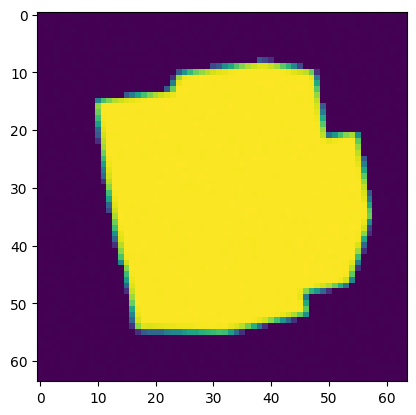

In [5]:
all_one_masks = all_masks[:, :, :, 0] + all_masks[: , : , :, 1] + all_masks[: , :, :, 2]
all_one_masks *= (1.0/all_one_masks.max())
plt.imshow(all_one_masks[0])
print(all_one_masks.shape)

In [63]:
def masstestAlt(mylist, locmodel):
    vectors = all_vectors[mylist]
    albedos = all_albedos[mylist // 57]
    inputs = inputList[mylist]
    testanswers = answerList[mylist]
    photos = all_photos[mylist]

    imgimg = locmodel.predict([inputs, vectors])

    differencemap = list()
    for i in range(imgimg.shape[0]):
        differencemap.append(normalizeNegativeImage(testanswers[i], all_masks[mylist[i] // lightjumps]))
    differencemapPred = list()
    for i in range(imgimg.shape[0]):
        differencemapPred.append(normalizeNegativeImage(imgimg[i], all_masks[mylist[i] // lightjumps]))
        
    
    result = albedos + imgimg
    result = np.clip(result, 0 ,1)
    #testanswers = np.clip(testanswers, 0 ,1)

    checkcheck = np.clip(albedos + testanswers,0,1)
    
    r0 =  np.concatenate(inputs, axis=1)
    r1 =  np.concatenate(differencemapPred, axis=1)
    r2 =  np.concatenate(differencemap, axis=1)
    r3 =  np.concatenate(result, axis=1)  
    r4 =  np.concatenate(checkcheck, axis=1)
    
    #r3 =  np.concatenate(np.take(intotheflames, [4,5,6,7], axis=0), axis=0)
    #r4 =  np.concatenate(np.take(imgimg, [4,5,6,7], axis=0), axis=0)
    #r5 =  np.concatenate(np.take(testanswers, [4,5,6,7], axis=0), axis=0)
    finalimage = np.concatenate([r0, r1, r2, r3,  r4], axis=0)
                                 #r3,r4, r5], 
    return finalimage

In [8]:
def GetDifference(num_images, light_jumps):
    photo = all_photos[num_images]
    albedo = all_albedos[num_images // light_jumps]
    mask = all_masks[num_images // light_jumps]
    return photo - albedo * mask
def normalizeNegativeImage(imim, mask):
    nonneg = imim - np.ones(imim.shape) * imim.min()
    nonneg = nonneg * (1.0/nonneg.max())
    return nonneg * mask

In [54]:
batch_size = 64
train_size = int(0.95 * len(all_photos)) # SMALL DATASET FOR TESTING
lightjumps = 57

answerList = list()
inputList = list()
print(len(all_photos))
for i in range(len(all_photos)):
    inputList.append(
        #GetDifference(i, lightjumps)
        all_normals[i// lightjumps]
    )
    answerList.append(
        GetDifference(i, lightjumps)
    )
            
        
answerList = np.array(answerList)
inputList = np.array(inputList)

datasetX = tf.data.Dataset.from_tensor_slices((inputList, all_vectors))
datasetY = tf.data.Dataset.from_tensor_slices(answerList)

dataset = tf.data.Dataset.zip((datasetX, datasetY))
dataset = dataset.shuffle(buffer_size=512, seed=13)

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

train_dataset = train_dataset.batch(64, drop_remainder=True)
test_dataset = test_dataset.batch(64,drop_remainder=True)
print(all_photos.shape, answerList.shape)

5700
(5700, 64, 64, 3) (5700, 64, 64, 3)


84 4
[-0.354 -0.707  0.612]


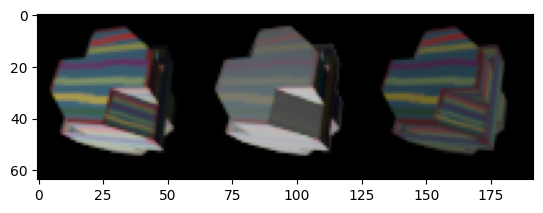

In [24]:
print(len(list(train_dataset)), len(list(test_dataset)))
def PhotoNormalMask(imtoshownum):
    imtoshow = np.concatenate( [
        all_photos[imtoshownum], 
        normalizeNegativeImage(answerList[imtoshownum], all_masks[imtoshownum // lightjumps]), 
        all_photos[imtoshownum] - answerList[imtoshownum]
        #np.repeat(answerList[imtoshownum][...,3:], 3, axis=2) 
    ]
                              , axis=1).astype("float32")
    plt.imshow(imtoshow)
print(all_vectors[1900])
PhotoNormalMask(1900)

In [79]:
def GiveModel():
    image_input = keras.layers.Input(shape=(64, 64, 3), name='image_input')
    x = keras.layers.Conv2D(4, (3, 3), activation='relu', padding="same")(image_input)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Conv2D(7, (3, 3), activation='relu', padding="same")(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Flatten()(x)
    
    vector_input = keras.layers.Input(shape=(3,), name='vector_input')
    y = keras.layers.Dense(256, activation='relu')(vector_input)
    
    # Объединение выходов
    combined = keras.layers.concatenate([x, y])
    
    # Полносвязный слой
    z = keras.layers.Dense(2*16*16, activation='tanh')(combined)
    do = keras.layers.Dropout(0.4)(z)
    #z = keras.layers.Dense(4*16*16, activation='relu')(do)
    #do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(4*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)

    resh = keras.layers.Reshape((16, 16, 4))(do)
    anticonv1 = keras.layers.Conv2DTranspose(4, (3, 3), strides=(2,2), padding='same', activation='tanh')(resh)
    output = keras.layers.Conv2DTranspose(3, (3, 3), strides=(2,2), padding='same', activation='tanh')(anticonv1)
    
    # Создание модели
    model = keras.models.Model(inputs=[image_input, vector_input], outputs=output)
    return model

In [80]:
g_optimizer_image=keras.optimizers.Adam(learning_rate=0.00005)

In [81]:
model = GiveModel()
model.compile(optimizer=g_optimizer_image, loss='mse')
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 64, 64, 4)    112         ['image_input[0][0]']            
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 32, 32, 4)   0           ['conv2d_8[0][0]']               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 32, 32, 7)    259         ['max_pooling2d_8[0][0]']        
                                                                                            

In [82]:
model.fit(train_dataset, epochs=300)

Epoch 1/300
84/84 [==============================] - 2s 16ms/step - loss: 0.0243
Epoch 2/300
84/84 [==============================] - 1s 12ms/step - loss: 0.0235
Epoch 3/300
84/84 [==============================] - 1s 12ms/step - loss: 0.0231
Epoch 4/300
84/84 [==============================] - 1s 13ms/step - loss: 0.0222
Epoch 5/300
84/84 [==============================] - 1s 12ms/step - loss: 0.0212
Epoch 6/300
84/84 [==============================] - 1s 12ms/step - loss: 0.0201
Epoch 7/300
84/84 [==============================] - 1s 12ms/step - loss: 0.0191
Epoch 8/300
84/84 [==============================] - 1s 12ms/step - loss: 0.0181
Epoch 9/300
84/84 [==============================] - 1s 12ms/step - loss: 0.0174
Epoch 10/300
84/84 [==============================] - 1s 12ms/step - loss: 0.0166
Epoch 11/300
84/84 [==============================] - 1s 13ms/step - loss: 0.0159
Epoch 12/300
84/84 [==============================] - 1s 14ms/step - loss: 0.0154
Epoch 13/300
84/84 [=====

1/1 [==============================] - 0s 128ms/step
(320, 768, 3)
Сверху вниз: Ввод // Разница(Пред.) // Разница(Факт.) // Результат (Пред.) // Результат (Факт.)  


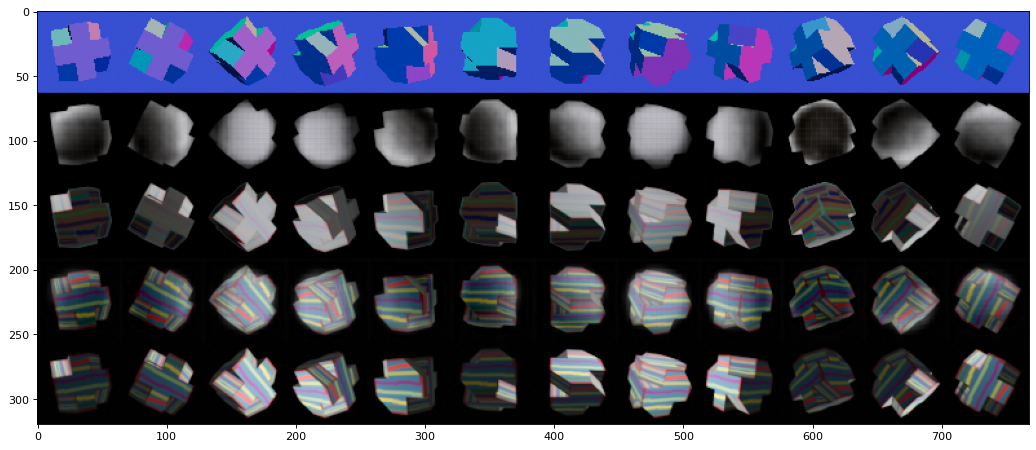

In [83]:
toinset = np.array([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500])
bigpicture = masstestAlt(toinset, model)
print(bigpicture.shape)
plt.figure(figsize=(16, 10), dpi=80)
print("Сверху вниз: Ввод // Разница(Пред.) // Разница(Факт.) // Результат (Пред.) // Результат (Факт.)  ")
plt.imshow(bigpicture.astype("float32"))

In [84]:
model.evaluate(test_dataset)

4/4 [==============================] - 0s 66ms/step - loss: 0.0089


0.008941711857914925

6/6 [==============================] - 0s 51ms/step
0.9839818179607391 -0.23081684112548828


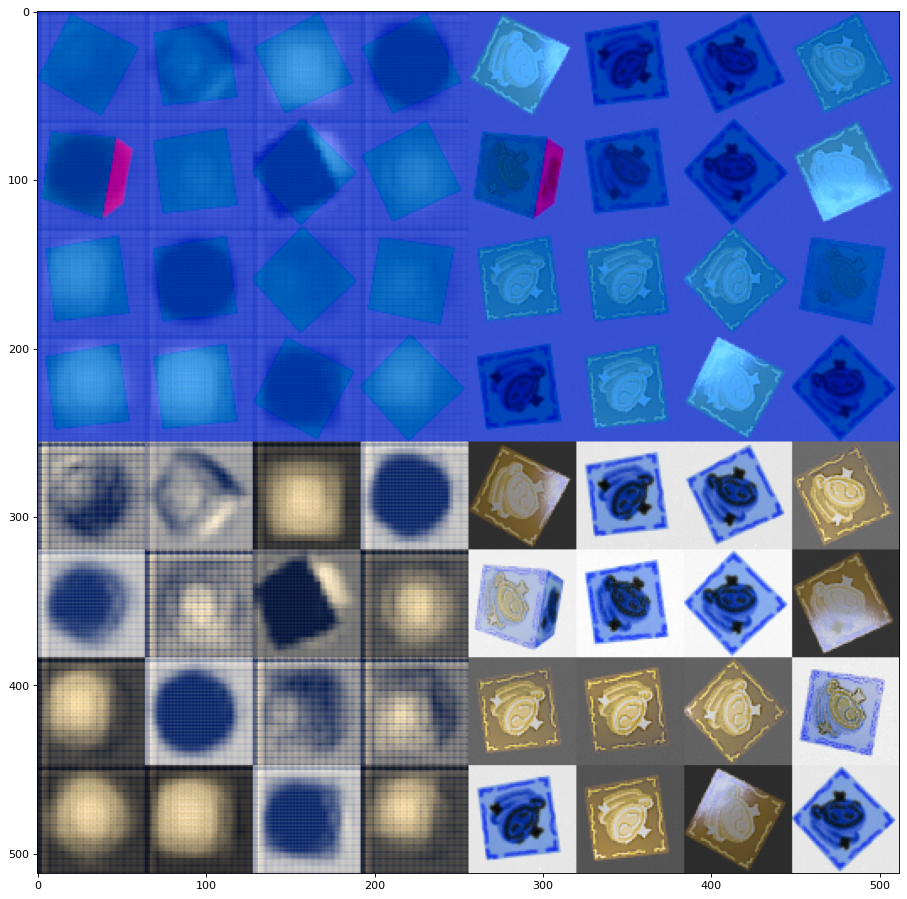

In [147]:
imgoutput = model.predict(test_dataset)
every_24th_image = imgoutput[::24]

dumblist = list(test_dataset)
dumb_albedos = np.empty((0,64,64,3))
for i in range(len(dumblist)):
    dumb_albedos = np.concatenate([dumb_albedos, dumblist[i][0][0]], axis=0)
dumb_answers = np.empty((0,64,64,3))
for i in range(len(dumblist)):
    dumb_answers = np.concatenate([dumb_answers, dumblist[i][1]], axis=0)
combined_image_fake = np.zeros((256, 256, 3))
combined_image_true = np.zeros((256, 256, 3))
raw_fake = np.zeros((256, 256, 3))
raw_true = np.zeros((256, 256, 3))
for i in range(4):  
    for j in range(4):  
        index = i * 4 + j
        raw_fake[i * 64:(i + 1) * 64, j * 64:(j + 1) * 64] =  (
            (every_24th_image[index] - every_24th_image[index].min()) / every_24th_image[index].ptp()
        )
        
        raw_true[i * 64:(i + 1) * 64, j * 64:(j + 1) * 64] = (
            (dumb_answers[index * 24] - dumb_answers[index * 24].min()) / dumb_answers[index * 24].ptp()
        )

        combined_image_fake[i * 64:(i + 1) * 64, j * 64:(j + 1) * 64] = dumb_albedos[index * 24] + every_24th_image[index]
        combined_image_true[i * 64:(i + 1) * 64, j * 64:(j + 1) * 64] = dumb_albedos[index * 24] + dumb_answers[index*24]

print(combined_image_fake.max(), combined_image_fake.min())
combined_image_fake = np.clip(combined_image_fake, 0 ,1 )
combined_image_true = np.clip(combined_image_true, 0 ,1 )
combined_image_image = np.concatenate([combined_image_fake, combined_image_true], axis=1)
combined_raw_image = np.concatenate([raw_fake, raw_true], axis=1)
combined_super_image = np.concatenate([combined_image_image, combined_raw_image], axis=0)
plt.figure(figsize=(14, 14), dpi=80)
plt.imshow(combined_super_image) 

In [86]:
#model.save("somewhatgoodrubic.keras")
# Попытка 1, 300 эпох. Картинка в мощных картинках.
# Явно что модель не понимает вообще ничего и просто выдает случаюную форму кубика, 
# Иногда она вообще не совпадает со входным изображением

In [149]:
#model.save("badrelightnormal001.keras")
# Попытка 1, 400 эпох. Картинка в мощных картинках.
# Модель снова не поняла ничего, даже не смотря на то что я генерировал освещение из нормалей.